# <center> DATA 558 Homework 7 </center>
<center> Cathy Jia </center>
<center> Due May 31st, 2019 by 11:59pm </center>

In [1]:
# Display all of the results.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics
from sklearn import multiclass
from sklearn.svm import LinearSVC
from itertools import combinations
from scipy.stats import mode

## Exercise 1

**Study Lab #7 and do exercises therein.**

## Exercise 2
- **Compute the gradient $\nabla F(\alpha)$ of $F$.**

The kernel support vector machine with the smoothed hinge loss writes as

$$\min_{\alpha\in\mathbb{R}^n} F =  \frac{1}{n}\sum_{i=1}^n l_{hh}(y_i, (K\alpha)_i) + \lambda \alpha^TK\alpha$$

where $(K\alpha)_i$ is the $i$th entry in the vector $K\alpha$,

$$
l_{hh}(y, t) =
\begin{cases}
0 & \text{if} & yt > 1+h  \\
\frac{(1+h-yt)^2}{4h} & \text{if} & |1-yt| \leq h \\
1-yt & \text{if} & yt < 1-h
\end{cases}
$$

and $h = 0.5.$

Then we can apply chain rule and subdifferentiation to find the gradient of $F$.

$$
\nabla F(\alpha) = \frac{1}{n} \sum_{i=1}^n \nabla l_{hh}(y_i, (K\alpha)_i) + 2\lambda K \alpha
$$

where $(K\alpha)_i$ is the $i$th entry in the vector $K\alpha$,

$$
\nabla l_{hh}(y, t) =
\begin{cases}
0 & \text{if} & yt > 1+h  \\
-\frac{yK(1+h-yt)}{2h} & \text{if} & |1-yt| \leq h \\
-yK & \text{if} & yt < 1-h
\end{cases}
$$

and $h = 0.5.$

- **Write a function `computegram` that computes, for any set of datapoints $x_1$, . . . , $x_n$, the kernel matrix $K$.**

In [2]:
def computegram(X, Y=None, sigma=0.5):
    '''
    Gaussian RBF
    '''
    if Y is None:
        Y = X
    K = (np.linalg.norm(X, axis=1)**2)[:, np.newaxis] + (np.linalg.norm(Y, axis=1)**2)[np.newaxis, :]
    K -= 2*(X.dot(Y.T))
    K = np.exp(-1/(2*sigma**2)*K)
    return K

- **Write a function `kerneleval` that computes, for any set of datapoints $x_1$, . . . , $x_n$ and a new datapoint $x^*$, the vector of kernel evaluations $[k(x_1, x^*), . . . , k(x_n, x^*)]^T.$**

In [3]:
def kerneleval_poly(X, Y=None, b=1, p=1):
    '''
    Polynomial kernel
    '''
    if Y is None:
        Y = X
    return (X.dot(Y.T)+b)**p

def kerneleval_linear(X, Y=None):
    '''
    Linear kernel
    '''
    if Y is None:
        Y = X
    return X.dot(Y.T)

- **Consider the Digits dataset (http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). Download and standardize the data, if you have not done so already.**

In [4]:
# Load data set
digits = load_digits()
X = digits.data
Y = digits.target

# Subset data
print('Unique class label:', np.unique(Y))
class1 = 0
class2 = 1
print('Selected 2 classes: %d and %d' % (class1, class2))
x = X
y = Y
idx = np.concatenate((np.where(Y==class1),np.where(Y==class2)), axis=1).reshape(-1)
x = x[idx]
y = y[idx]

# Split train set and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Standardize data
scalar  = StandardScaler().fit(x_train)
x_train = scalar.transform(x_train)
x_test  = scalar.transform(x_test)

# Change label to +/- 1
y_train[y_train!=class2] = -1
y_test[y_test!=class2] = -1

# Check the number of data and the number of dimensions
print('Training set: n = %d, d = %d' % (x_train.shape[0], x_train.shape[1]))
print('Test set: n = %d, d = %d' % (x_test.shape[0], x_test.shape[1]))

Unique class label: [0 1 2 3 4 5 6 7 8 9]
Selected 2 classes: 0 and 1
Training set: n = 270, d = 64
Test set: n = 90, d = 64


- **Write a function `mysvm` that implements the fast gradient algorithm to train the kernel support vector machine with the smoothed hinge loss. The function takes as input the initial step-size value for the backtracking rule and a stopping criterion based on the norm of the gradient.**

In [5]:
def obj(alpha, K, y, lamb, h=0.5):
    '''
    Find objective value
    '''
    n, d = K.shape
    loss = 0
    for i in range(n):
        diff = 1 - y[i] * (K.dot(alpha)[i])
        if diff < h:
            loss += 0
        elif diff >  h:
            loss += diff
        else:
            loss += ((diff + h)**2) / (4*h)
    obj = loss / n + lamb*alpha.T.dot(K).dot(alpha)
    return obj

def computegrad(alpha, K, y, lamb, h=0.5):
    '''
    Find gradient of F
    '''
    n, d = K.shape
    loss = 0
    for i in range(n):
        diff = 1 - y[i] * (K.dot(alpha)[i])
        if diff < h:
            loss += 0
        elif diff >  h:
            loss -= y[i] * K[i]
        else:
            loss -= (y[i] * K[i] * (diff + h)) / (2*h)
    grad = loss / n + 2 * lamb * (K.dot(alpha))
    return grad

def backtracking(beta, grad, K, y, lamb, eta=1, max_iter=20):
    '''
    Apply backtracking rule to find eta
    '''
    norm_grad = np.linalg.norm(grad)
    found_eta = 0
    t = 0
    while t < max_iter:
        if obj(beta-eta*grad, K, y, lamb) < obj(beta, K, y, lamb) - 0.5 * eta * norm_grad ** 2:
            break
        else:
            eta *= 0.8
            t += 1
    return eta

def mysvm(beta_theta_init, eta_init, K, y, lamb, max_iter=100, eps=0.001):
    '''
    Apply fast gradient descent to find beta values
    '''
    beta = beta_theta_init
    theta = beta_theta_init
    eta = eta_init
    grad = computegrad(theta, K, y, lamb)
    beta_vals = [beta]
    t = 0
    while np.linalg.norm(grad) > eps and t < max_iter:
        # backtracking rule
        eta = backtracking(theta, grad, K, y, lamb, eta=eta)
        beta_new = theta - eta * grad
        theta = beta_new + t/(t+3) * (beta_new - beta)
        grad = computegrad(theta, K, y, lamb)
        beta = beta_new
        beta_vals.append(beta_new)
        t += 1
    return np.array(beta_vals)

- **Train your kernel support vector machine with the smoothed hinge loss and the polynomial kernel of order 7 on the the Digits dataset, tuning the regularization parameter $\lambda$ using cross-validation. The *p*th order polynomial kernel is given by $k(x, y) = (x^T y+b)^p$. You may take $b = 1$.**

In [6]:
def objective_plot(betas, K, y, lamb):
    '''
    Plot objective values over iterations
    '''
    n = np.size(betas, 0)
    objs = np.zeros(n)
    for i in range(0, n):
        objs[i] = obj(betas[i, :], K, y, lamb)
    plt.figure()
    plt.plot(np.array(range(n)), objs)
    plt.xlabel('Iteration')
    plt.ylabel('Objective Value')
    plt.title('Objective Value vs. Iteration\nlambda = %.10f' % lamb)
    plt.show()

In [7]:
# Tune the regularization parameter lamb using cross-validation
clf = LogisticRegressionCV(Cs=50).fit(x_train, y_train)
n, d = x_train.shape
lamb_opt = 1/ (2 * n * clf.C_)
print('Optimal lambda = %.10f' % lamb_opt)

Optimal lambda = 0.0069029513


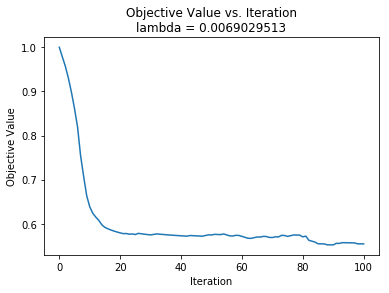

In [8]:
# Kernel support vector machine with the smoothed hinge loss
dists = sklearn.metrics.pairwise.pairwise_distances(x_train).reshape(-1)
sigma = np.median(dists)
K = computegram(x_train, x_train, sigma)
beta_theta = np.zeros(n)
eta = 1/(max(np.linalg.eigvals(1/n*K.dot(K.T))) + lamb_opt)

betas = mysvm(beta_theta, eta, K=K, y=y_train, lamb=lamb_opt)
objective_plot(betas, K, y_train, lamb_opt)

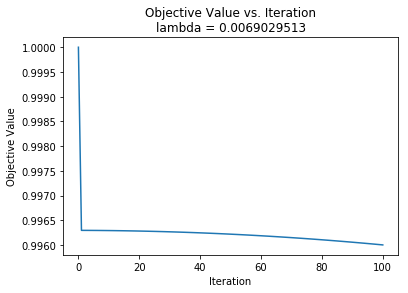

In [9]:
# Polynomial kernel of order 7
K = kerneleval_poly(x_train, x_train, 1, 7)
beta_theta = np.zeros(n)
eta = 1/(max(np.linalg.eigvals(1/n*K.dot(K.T))) + lamb_opt)

betas = mysvm(beta_theta, eta, K=K, y=y_train, lamb=lamb_opt)
objective_plot(betas, K, y_train, lamb_opt)

- **Compare the performance of kernel SVMs with different kernels (polynomial kernels with different orders, Gaussian RBF with different bandwidths, etc.).**

In [10]:
def predict(beta, X, **kwargs):
    '''
    Make prediction
    '''
    n = len(X)
    y_pred = np.zeros(n)
    y_vals = np.zeros(n)
    for i in range(n):
        if 'sigma' in kwargs:
            sigma = kwargs['sigma']
            K = computegram(x_train, X[i, :].reshape(1, -1), sigma=sigma).reshape(-1)
            y_vals[i] = K.dot(beta)
        elif 'p' in kwargs:
            p = kwargs['p']
            K = kerneleval_poly(x_train, X[i, :].reshape(1, -1), b=1, p=p).reshape(-1)
            y_vals[i] = K.dot(beta)
        else:
            K = kerneleval_linear(x_train, X[i, :].reshape(1, -1)).reshape(-1)
            y_vals[i] = K.dot(beta)
    y_pred = np.sign(y_vals)
    y_pred = y_pred.astype(int)
    return y_pred, y_vals

def me_error(beta, X, Y, **kwargs):
    '''
    Compute classification error
    '''
    pred, vals = predict(beta, X, **kwargs)
    err = np.mean(pred != Y)
    return err, pred, vals

def evaluate(X, Y, sigma=None, p=None):
    '''
    Make prediction and report classification error
    '''
    n, d = x_train.shape
    beta_theta = np.zeros(n)
    if sigma:
        K = computegram(x_train, x_train, sigma)
        eta = 1/(max(np.linalg.eigvals(1/n*K.dot(K.T))) + lamb_opt)
        betas = mysvm(beta_theta, eta, K, y=y_train, lamb=lamb_opt)
        error, pred, vals = me_error(betas[-1, :], X, Y, sigma=sigma)
    elif p:
        K = kerneleval_poly(x_train, x_train, b=1, p=p)
        eta = 1/(max(np.linalg.eigvals(1/n*K.dot(K.T))) + lamb_opt)
        betas = mysvm(beta_theta, eta, K, y=y_train, lamb=lamb_opt)
        error, pred, vals = me_error(betas[-1, :], X, Y, p=p)
    else:
        K = kerneleval_linear(x_train, x_train)
        eta = 1/(max(np.linalg.eigvals(1/n*K.dot(K.T))) + lamb_opt)
        betas = mysvm(beta_theta, eta, K, y=y_train, lamb=lamb_opt)
        error, pred, vals = me_error(betas[-1, :], X, Y, p=p)
    print('Misclassification error is %.5f' % error)

In [11]:
# Gaussian RBF
print('Gaussian RBF')
for sigma in [1, 3, 5, 7, 9]:
    print('Bandwidth = %d' % sigma)
    evaluate(x_train, y_train, sigma=sigma)

# Polynomial kernels
print('\nPolynomial kernel')
for p in [1, 3, 5, 7, 9]:
    print('Order = %d' % p)
    evaluate(x_train, y_train, p=p)

Gaussian RBF
Bandwidth = 1
Misclassification error is 0.00000
Bandwidth = 3
Misclassification error is 0.00000
Bandwidth = 5
Misclassification error is 0.00370
Bandwidth = 7
Misclassification error is 0.00741
Bandwidth = 9
Misclassification error is 0.03333

Polynomial kernel
Order = 1
Misclassification error is 0.00000
Order = 3
Misclassification error is 0.00741
Order = 5
Misclassification error is 0.01481
Order = 7
Misclassification error is 0.01481
Order = 9
Misclassification error is 0.01852


After running the algorithm for kernel SVMs with different kernels, we can see that smaller bandwidth for Gaussian RBF and smaller order for polynomial kernel gives smaller misclassification error, i.e., better performance.

## Exercise 3 Data Competition Project

**In this exercise, you are going to train support vector machines (SVMs) using the data competition 2 project dataset (with 100 classes). You will consider here all classes in the dataset. You may work on this exercise on your own computer first. Note, however, that you need AWS to run the experiments for this entire exercise.**

In [12]:
# Load data
x_train = np.load('train_features.npy')
y_train = np.load('train_labels.npy')
x_val = np.load('val_features.npy')
y_val = np.load('val_labels.npy')
x_test = np.load('test_features.npy')

print('Training set')
print('Number of observations: %d' % x_train.shape[0])
print('Number of dimension: %d' % x_train.shape[1])
print('\nValidation set')
print('Number of observations: %d' % x_val.shape[0])
print('Number of dimension: %d' % x_val.shape[1])

Training set
Number of observations: 50000
Number of dimension: 4096

Validation set
Number of observations: 10000
Number of dimension: 4096


- **In a one-vs-one fashion, for each pair of classes, train a linear SVM classifier using scikit-learn’s function `LinearSVC`, with the default value for the regularization parameter. Compute the multi-class misclassification error obtained using these classifiers trained in a one-vs-one fashion.**

In [13]:
svm = LinearSVC()
clf = multiclass.OneVsOneClassifier(svm, n_jobs=-1)
clf.fit(x_train,y_train)

OneVsOneClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=-1)

In [14]:
# Validation set
score = clf.score(x_val, y_val)
error = 1 - score
print('Multi-class misclassification error on validation set is %.2f' % error)

Multi-class misclassification error on validation set is 0.48


In [ ]:
# Test set
pred = clf.predict(x_test)

# Write to submission.csv
df = pd.read_csv('sample_submission.csv')
df['Category'] = pred
df.to_csv('submission.csv',index=False)

- **In a one-vs-rest fashion, for each class, train a linear SVM classifier using scikit-learn’s function `LinearSVC`, with the default value for $\lambda c$. Compute the multi-class misclassification error obtained using these classifiers trained in a one-vs-rest fashion.**

In [15]:
# Train OvR classifiers
clf = LinearSVC(multi_class='ovr')
clf.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [16]:
# Validation set
score = clf.score(x_val, y_val)
error = 1 - score
print('Multi-class misclassification error on validation set is %.2f' % error)

Multi-class misclassification error on validation set is 0.55


In [ ]:
# Test set
pred = clf.predict(x_test)

# Write to submission.csv
df = pd.read_csv('sample_submission.csv')
df['Category'] = pred
df.to_csv('submission.csv',index=False)

- **Redo all questions above now using your own code for the linear SVMs from Exercise 1. Make to sure to run preliminary experiments to decide how to set the stopping criterion to a value that allows the experiments to complete in a reasonable amount of time.**

In [ ]:
def subsetData_OvO(X, Y, class1, class2):
    # Subset data
    x = X
    y = Y
    idx = np.concatenate((np.where(Y==class1),np.where(Y==class2)), axis=1).reshape(-1)
    x = x[idx]
    y = y[idx]
    # Standardize data
    scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    # Change label to +/- 1
    y[y==class1] = -1
    y[y==class2] = 1
    
    return x, y

def subsetData_OvR(X, Y, class1):
    # Subset data
    x = X
    y = Y
    # Standardize data
    scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    # Change label to +/- 1
    y[y==class1] = 1
    y[y!=class1] = -1
    
    return x, y

def predict_svm(X, clf, class1, class2):
    n = len(X)
    pred = np.zeros(n)
    vals = np.zeros(n)
    for i in range(n):
        K = kerneleval_linear(X, X[i,:].reshape(1, -1)).reshape(-1)
        vals[i] = K.dot(clf)
    pred = np.sign(vals)
    pred = pred.astype(int)
    pred[pred==-1] = class1
    pred[pred==1] = class2
    return pred

def predict_clf(X, clf, class1, class2):
    pred = clf.predict(X)
    pred[pred==-1] = class1
    pred[pred==1] = class2
    return pred

def multiPredict(X, pairs, clfs, svm=False, ovo=True):
    preds = np.array([[0]]*X.shape[0])
    for i in range(len(clfs)):
        if svm:
            pred = predict_svm(X, clfs[i], pairs[i][0], pairs[i][1])
        else:
            pred = predict_clf(X, clfs[i], pairs[i][0], pairs[i][1])
        pred = np.array([pred]).T
        preds = np.concatenate((preds, pred), axis=1)
    if ovo:
        pred_final, cnt = mode(preds, axis=1)
    else:
        pred_final = max(preds, axis=1)
    return pred_final.reshape(-1)

In [ ]:
# Train OvO classifiers
arr = [i for i in range(100)]
pairs = list(combinations(arr, 2))
clfs = []

# Train SVM with linear kernel
n, d = x_train.shape
K = kerneleval_linear(x_train)
lamb = 0.000001

for pair in pairs:
    class1 = pair[0]
    class2 = pair[1]
    xtrain, ytrain = subsetData_OvO(x_train, y_train, class1, class2)
    k = K[y_train==class1, y_train==class2]
    eta = 1/(max(np.linalg.eigvals(1/n*k.dot(k.T))) + lamb)
    betas = mysvm(np.zeros(n), eta, k, ytrain, lamb, max_iter=10, eps=0.01)
    clf = betas[-1:].reshape(-1)
    clfs.append(clf)

In [ ]:
# Test set
pred = multiPredict(x_test, pairs, clfs, svm=True)

# Write to submission.csv
df = pd.read_csv('sample_submission.csv')
df['Category'] = pred
df.to_csv('submission.csv',index=False)

In [ ]:
# Train OvR classifiers
arr = [i for i in range(100)]
pairs = []
clfs = []

# Train SVM with linear kernel
n, d = x_train.shape
K = kerneleval_linear(x_train)
lamb = 0.000001
eta = 1/(max(np.linalg.eigvals(1/n*K.dot(K.T))) + lamb)

for cls in arr:
    pairs.append([cls, -1])
    xtrain, ytrain = subsetData_OvR(x_train, y_train, cls)
    betas = mysvm(np.zeros(n), eta, K, ytrain, lamb, max_iter=10, eps=0.01)
    clf = betas[-1:].reshape(-1)
    clfs.append(clf)

In [ ]:
# Test set
pred = multiPredict(x_test, pairs, clfs, svm=True, ovo=False)

# Write to submission.csv
df = pd.read_csv('sample_submission.csv')
df['Category'] = pred
df.to_csv('submission.csv',index=False)